In [28]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import numpy.random as rnd

In [44]:
def synth_pdf_vec(size=1):
    x = np.zeros(shape=(size,1))
    for k in range(size):
        if rnd.random(1) < 0.4:
            x[k] = 0.0
        else:
            x[k] = rnd.random(1)
    return x

In [2]:
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [46]:
img_data = mnist.train.next_batch(2)
img = np.reshape(img_data[0],(784,2))

ds_rate = 0.1
learning_rate = 0.001
batch_size = 100
training_iter = 2000
disp_step = 100

enc_in_size = img.shape[0]
dec_in_size = int(np.round(img.shape[0]*ds_rate))

In [47]:
tf.reset_default_graph()

init_enc = tf.contrib.layers.xavier_initializer()
init_dec = tf.contrib.layers.xavier_initializer()

e_in = tf.placeholder(dtype=tf.float32, shape=[None, enc_in_size], name='e_in')
synth_in = tf.placeholder(tf.float32, shape=[None, dec_in_size], name='synth_in')
keep_prob = tf.placeholder(tf.float32)

e1s = 200
ew1 = tf.Variable(init_enc([enc_in_size, e1s]), name='ew1')
eb1 = tf.Variable(init_enc([e1s]), name='eb1')

e2s = 50
ew2 = tf.Variable(init_enc([e1s, e2s]), name='ew2')
eb2 = tf.Variable(init_enc([e2s]), name='eb2')

e3s = dec_in_size
ew3 = tf.Variable(init_enc([e2s, e3s]), name='ew3')
eb3 = tf.Variable(init_enc([e3s]), name='eb3')

d1s = 50
dw1 = tf.Variable(init_dec([dec_in_size, d1s]), name='dw1')
db1 = tf.Variable(init_dec([d1s]), name='db1')

d2s = 200
dw2 = tf.Variable(init_dec([d1s, d2s]), name='dw2')
db2 = tf.Variable(init_dec([d2s]), name='db2')

d3s = enc_in_size
dw3 = tf.Variable(init_dec([d2s, d3s]), name='dw3')
db3 = tf.Variable(init_dec([d3s]), name='db3')

theta = [ew1, eb1, ew2, eb2, ew3, eb3,dw1, db1, dw2, db2, dw3, db3]

In [48]:
def encoder(x, keep_prob=0.9):
    
    e0 = tf.nn.relu(tf.matmul(x, ew1) + eb1)
    e1 = tf.nn.relu(tf.matmul(tf.nn.dropout(e0, keep_prob), ew2) + eb2)
    e2 = tf.nn.relu(tf.matmul(tf.nn.dropout(e1, keep_prob), ew3) + eb3)
    
    return e2

def decoder(x, keep_prob=0.9):
    
    d0 = tf.nn.relu(tf.matmul(x, dw1) + db1)
    d1 = tf.nn.relu(tf.matmul(tf.nn.dropout(d0, keep_prob), dw2) + db2)
    d2 = tf.nn.sigmoid(tf.matmul(tf.nn.dropout(d1, keep_prob), dw3) + db3)
    
    return d2

In [49]:
comp = encoder(e_in)
reco = decoder(comp)

synthesized = decoder(synth_in)

loss = tf.reduce_mean(tf.square(tf.subtract(e_in,reco)))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=theta)

Optimization step 0 -> Loss = 0.231605

Optimization step 100 -> Loss = 0.0586627

Optimization step 200 -> Loss = 0.0425584

Optimization step 300 -> Loss = 0.0390264

Optimization step 400 -> Loss = 0.0339382

Optimization step 500 -> Loss = 0.035253

Optimization step 600 -> Loss = 0.0324271

Optimization step 700 -> Loss = 0.0295333

Optimization step 800 -> Loss = 0.0318614

Optimization step 900 -> Loss = 0.0289892

Optimization step 1000 -> Loss = 0.0298959

Optimization step 1100 -> Loss = 0.0303959

Optimization step 1200 -> Loss = 0.0309668

Optimization step 1300 -> Loss = 0.0273861

Optimization step 1400 -> Loss = 0.0293873

Optimization step 1500 -> Loss = 0.0259834

Optimization step 1600 -> Loss = 0.0275777

Optimization step 1700 -> Loss = 0.0291623

Optimization step 1800 -> Loss = 0.0271355

Optimization step 1900 -> Loss = 0.025421

Concluded training phase.

What would you like to do next? synthesize


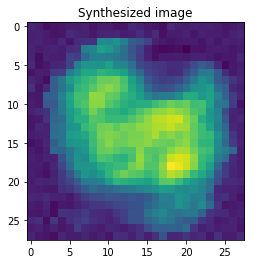

What would you like to do next? synthesize


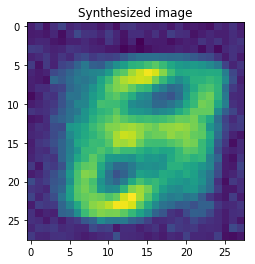

In [ ]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    for k in range(training_iter):
        
        batch_raw = mnist.train.next_batch(batch_size)
        batch = np.reshape(batch_raw[0].flatten(),[batch_size,784])
        
        l, opt = sess.run([loss, optimizer], feed_dict={
            e_in: batch
        })
        
        if k%disp_step==0:
            print('Optimization step '+str(k)+' -> Loss = '+str(l)+'\n')
            
    
    print('Concluded training phase.\n')
        
    exit = False
    while not exit:
        
            requ = input('What would you like to do next? ')
        
            if requ=='exit':
                exit = True
            elif requ=='test accuracy':
                #TODO
                print('accuracy measure launched\n')
            elif requ=='synthesize':
                test_pdf_in = np.reshape(synth_pdf_vec(dec_in_size),[1,dec_in_size])
                syn = sess.run(synthesized, feed_dict={
                    synth_in:test_pdf_in
                }) 
                plt.imshow(np.reshape(syn,(28,28)))
                plt.title('Synthesized image')
                plt.show()
            elif requ=='test single':
                print('Pulling random test image...\n')
                test_img = mnist.train.next_batch(1)[0]
                plt.imshow(np.reshape(test_img,(28,28)))
                plt.title('Original image')
                plt.show()
                aec_input = np.reshape(test_img.flatten(),[1,784])
                reco_img, inter_comp = sess.run([reco, comp], feed_dict={
                    e_in: test_img
                })
                plt.imshow(np.reshape(reco_img,(28,28)))
                plt.title('Reconstructed image')
                plt.show()
                plt.hist(test_img.flatten(), bins=100)
                plt.title('Original image histogram')
                plt.show()
                plt.hist(inter_comp.flatten(), bins=100)
                plt.title('Decoder input histogram')
                plt.show()
                plt.hist(reco_img.flatten(), bins=100)
                plt.title('Decoder output histogram')
                plt.show()
            elif requ=='charm':
                print('You\'re looking exceptionally handsome today, sweetie ;)')
            else:
                print('Did not understand input, sorry...\n')
        
    sess.close()
    
print('All done!')